In [25]:
%matplotlib inline

In [26]:
#import matplotlib
#matplotlib.use("pgf")

In [27]:
import math 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib.gridspec import GridSpec
from scipy.optimize import brentq

import cvxpy as cp

from tqdm.notebook import trange

In [41]:
from rsnn.spike_train.generator import PeriodicSpikeTrainGenerator
from rsnn.spike_train.spike_train import SpikeTrain
from rsnn.spike_train.periodic_spike_train import PeriodicSpikeTrain, MultiChannelPeriodicSpikeTrain
from rsnn.rsnn.neuron import Neuron
from rsnn.spike_train.measure import single_channel_correlation

In [29]:
plt.style.use('paper')

In [30]:
rng = np.random.default_rng(7)

# Supervised Learning for Spiking Neurons

In [31]:
num_inputs = 1000 # number of synapses
delays = rng.uniform(1.0, 20.0, num_inputs)
synapse_beta, soma_decay = 4, 5
firing_threshold = 1.0
wmin, wmax = -0.1, 0.1

period = 100.0
firing_rate, rel_refractory_period, abs_refractory_period = 0.1, 5.0, 5.0
refractory_weight = 1

In [32]:
times = np.linspace(0, period, 10000)

In [33]:
def input_spike_resp(t):
    tmax = (math.log(synapse_beta) - math.log(soma_decay)) / (1 / soma_decay - 1 / synapse_beta)
    gamma = 1 / (math.exp(-tmax / soma_decay) - math.exp(-tmax / synapse_beta))

    if isinstance(t, np.ndarray):
        z = gamma * (np.exp(-t / soma_decay) - np.exp(-t / synapse_beta))
        z[t < 0] = 0.0
        return z
    
    if t < 0:
        return 0.0
    
    return gamma * (np.exp(-t / soma_decay) - np.exp(-t / synapse_beta))

def input_spike_resp_deriv(t):
    tmax = (math.log(synapse_beta) - math.log(soma_decay)) / (1 / soma_decay - 1 / synapse_beta)
    gamma = 1 / (math.exp(-tmax / soma_decay) - math.exp(-tmax / synapse_beta))

    if isinstance(t, np.ndarray):
        z = gamma * (np.exp(-t / synapse_beta) / synapse_beta - np.exp(-t / soma_decay) / soma_decay)
        z[t < 0] = 0.0
        return z
    
    if t < 0:
        return 0.0
    
    return gamma * (np.exp(-t / synapse_beta) / synapse_beta - np.exp(-t / soma_decay) / soma_decay)

def refractory_spike_resp(t):
    if isinstance(t, np.ndarray):
        z = -refractory_weight * np.exp(- (t - abs_refractory_period) / soma_decay)
        z[t <= abs_refractory_period] = -np.inf
        z[t <= 0] = 0.0
        return z
    
    if t <= 0:
        return 0.0
    
    if t <= abs_refractory_period:
        return -np.inf
    
    return -refractory_weight * np.exp(- (t - abs_refractory_period) / soma_decay)

def refractory_spike_resp_deriv(t):
    if isinstance(t, np.ndarray):
        z = refractory_weight / soma_decay * np.exp(- (t - abs_refractory_period) / soma_decay)
        z[t <= abs_refractory_period] = 0.0
        return z

    if t <= abs_refractory_period:
        return 0.0
    
    return refractory_weight / soma_decay * np.exp(- (t - abs_refractory_period) / soma_decay)

In [34]:
def potential(t, delays, weights, input_spike_trains, modulo=True):
    if isinstance(t, np.ndarray):
        if modulo:
            y = np.array([
                np.sum(input_spike_resp((t[None,:] - delays[k] - input_spike_trains.spike_trains[k].firing_times[:,None])%period), axis=0) for k in range(num_inputs)
            ])
            return weights@y
        
        y = np.array([
            np.sum(input_spike_resp((t[None,:] - delays[k] - input_spike_trains.spike_trains[k].firing_times[:,None])), axis=0) for k in range(num_inputs)
        ])
        return weights@y  
        
    if modulo:
        y = np.array([
            np.sum(input_spike_resp((t - delays[k] - input_spike_trains.spike_trains[k].firing_times)%period), axis=0) for k in range(num_inputs)
        ])
        return weights@y
    
    y = np.array([
        np.sum(input_spike_resp((t - delays[k] - input_spike_trains.spike_trains[k].firing_times)), axis=0) for k in range(num_inputs)
    ])
    return weights@y  

def potential_deriv(t, delays, weights, input_spike_trains, modulo=True):
    if isinstance(t, np.ndarray):
        if modulo:
            y = np.array([
                np.sum(input_spike_resp_deriv((t[None,:] - delays[k] - input_spike_trains.spike_trains[k].firing_times[:,None])%period), axis=0) for k in range(num_inputs)
                ])
            return weights@y
        
        y = np.array([
                np.sum(input_spike_resp_deriv((t[None,:] - delays[k] - input_spike_trains.spike_trains[k].firing_times[:,None])), axis=0) for k in range(num_inputs)
            ])
        return weights@y
    
    if modulo:
        y = np.array([
            np.sum(input_spike_resp((t - delays[k] - input_spike_trains.spike_trains[k].firing_times)%period), axis=0) for k in range(num_inputs)
            ])
        return weights@y  
    
    y = np.array([
            np.sum(input_spike_resp((t - delays[k] - input_spike_trains.spike_trains[k].firing_times)), axis=0) for k in range(num_inputs)
        ])
    return weights@y

def threshold(t, target_spike_train, modulo=True):
    if isinstance(t, np.ndarray):
        if modulo: 
            return firing_threshold - np.sum(refractory_spike_resp((t[None,:] - target_spike_train.firing_times[:,None])%period), axis=0)

        return firing_threshold - np.sum(refractory_spike_resp((t[None,:] - target_spike_train.firing_times[:,None])), axis=0)
    
    if modulo: 
        return firing_threshold - np.sum(refractory_spike_resp((t - target_spike_train.firing_times)%period), axis=0)        
    return firing_threshold - np.sum(refractory_spike_resp((t - target_spike_train.firing_times)), axis=0)

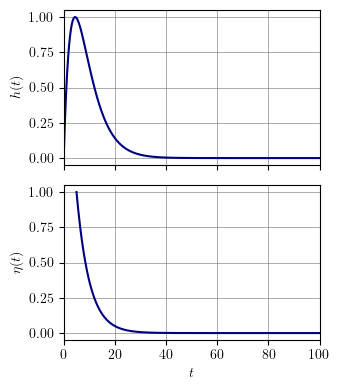

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(3.5, 4))

axes[0].plot(times, input_spike_resp(times), c="C2", label=r"$g_0 * g_k$")
axes[1].plot(times, -refractory_spike_resp(times), c="C2", label=r"$-g_0$")
axes[0].set_ylabel(r"$h(t)$")
axes[1].set_ylabel(r"$\eta(t)$")
axes[1].set_xlabel(r"$t$")
axes[1].set_xlim(0, period)

fig.tight_layout()
fig.savefig('spike_responses.pgf')
#plt.show()

In [19]:
spike_train_generator = PeriodicSpikeTrainGenerator(firing_rate, abs_refractory_period, rel_refractory_period)

In [20]:
for period in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
spike_trains = spike_train_generator.rand(period, 10000)
#input_spike_train = spike_train_generator.rand(period)
#input_spike_trains = MultiChannelPeriodicSpikeTrain(
#    period, 
#    num_inputs,
#    [input_spike_train.firing_times]*num_inputs
#)


Multi-channel periodic spike train sampling:   0%|          | 0/10000 [00:00<?, ?it/s]

In [24]:
num_spikes = np.array([spike_train.num_spikes for spike_train in spike_trains.spike_trains])

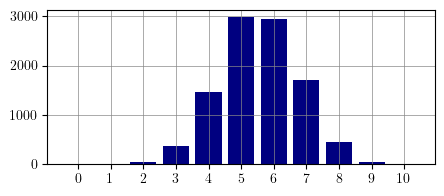

In [36]:
unique, counts = np.unique(num_spikes, return_counts=True)

fig, ax = plt.subplots(1, 1, figsize=(5, 2))
ax.bar(unique, counts, color="C2")
ax.set_xticks(np.arange(np.min(num_spikes), np.max(num_spikes)+1))
plt.show()

# Computing Weights

In [55]:
def compute_spike_train(weights):
    spike_train = target_spike_train.copy()
    
    fun = lambda t_: potential(t_, delays, weights, input_spike_trains) - threshold(t_, spike_train, modulo=False)

    ta = spike_train.firing_times[-1] + abs_refractory_period
    while(ta < 2*period):
        tb = ta + 1
        if fun(ta) * fun(tb) <= 0:
            t = brentq(fun, ta, tb)
            spike_train.append(t)
            ta += abs_refractory_period
        else:
            ta += 1

    return spike_train

In [48]:
def get_y_z(target_spike_train, input_spike_trains):    
    extended_firing_times = np.concatenate([
        target_spike_train.firing_times - period,
        target_spike_train.firing_times,
        target_spike_train.firing_times + period
    ])

    times = np.arange(0, period, 1e-2)
    time_diff = times[:,None] - extended_firing_times[None,:]
    mask_slope = np.any(np.abs(time_diff) < 1.0, axis=1)
    t_slope = times[mask_slope]
    y_slope = np.stack(
        [np.sum(
            input_spike_resp_deriv(
                (t_slope[:,None] - delays[k] - input_spike_trains.spike_trains[k].firing_times[None,:]) % period
            ),
            axis=1) for k in range(num_inputs)], 
        axis=1)
    z_slope = np.full_like(t_slope, 0.5)

    times = np.arange(0, period, 1e-2)
    time_diff = times[:,None] - extended_firing_times[None,:]
    mask_level_f = np.any((time_diff > -1.0) & (time_diff < 0.0), axis=1)
    t_level_f = times[mask_level_f]
    y_level_f = np.stack(
        [np.sum(
            input_spike_resp(
                (t_level_f[:,None] - delays[k] - input_spike_trains.spike_trains[k].firing_times[None,:]) % period
            ),
            axis=1) for k in range(num_inputs)], 
        axis=1)
    z_level_f = firing_threshold - np.sum(
        refractory_spike_resp(
            (t_level_f[:,None] - target_spike_train.firing_times[None,:]) % period
        ), axis=1)

    times = np.arange(0, period, 1e-1)
    time_diff = times[:,None] - extended_firing_times[None,:]
    mask_level = np.all((time_diff > abs_refractory_period) | (time_diff < -1.0), axis=1)
    t_level = times[mask_level]
    y_level = np.stack(
        [np.sum(
            input_spike_resp(
                (t_level[:,None] - delays[k] - input_spike_trains.spike_trains[k].firing_times[None,:]) % period
            ),
            axis=1) for k in range(num_inputs)], 
        axis=1)
    z_level = 0.0 - np.sum(
        refractory_spike_resp(
            (t_level[:,None] - target_spike_train.firing_times[None,:]) % period
        ), axis=1)

    t_firing = np.copy(target_spike_train.firing_times)
    y_firing = np.stack(
        [np.sum(
            input_spike_resp(
                (target_spike_train.firing_times[:,None] - delays[k] - input_spike_trains.spike_trains[k].firing_times[None,:]) % period
            ),
            axis=1) for k in range(num_inputs)], 
        axis=1)
    z_firing = firing_threshold - np.sum(
        refractory_spike_resp(
            (target_spike_train.firing_times[:,None] - target_spike_train.firing_times[None,:]) % period
        ), axis=1)

    return y_firing, z_firing, y_level_f, z_level_f, y_level, z_level, y_slope, z_slope

In [94]:
def solve(y_firing, z_firing, y_level_f, z_level_f, y_level, z_level, y_slope, z_slope):
    weights = cp.Variable(num_inputs)
    objective = cp.Minimize(cp.norm1(weights))
    constraints = [
        y_firing @ weights == z_firing, 
        y_level_f @ weights <= z_level_f, 
        y_level @ weights <= z_level, 
        y_slope @ weights >= z_slope,
        weights >= wmin,
        weights <= wmax
    ]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver="GUROBI")
    return prob.status, 1 - np.count_nonzero(weights.value)/num_inputs

In [101]:
results = []
for i in trange(50):
    delays = rng.uniform(1.0, 60.0, num_inputs)
    for num_neurons in [1, 10, 100]:
        target_spike_train = PeriodicSpikeTrain(spike_trains.period, spike_trains.spike_trains[i].firing_times)
        input_spike_trains = MultiChannelPeriodicSpikeTrain(
            spike_trains.period, 
            num_inputs,
            [spike_trains.spike_trains[(i*100 + k%num_neurons)%10000].firing_times for k in range(num_inputs)]
        )
        y_firing, z_firing, y_level_f, z_level_f, y_level, z_level, y_slope, z_slope = get_t_y_z(target_spike_train, input_spike_trains)
        status, sparsity = solve(y_firing, z_firing, y_level_f, z_level_f, y_level, z_level, y_slope, z_slope)
        results.append({"i":i, "num_neurons":num_neurons, "status":status, "sparsity":sparsity})

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/haguettaz/opt/anaconda3/envs/rsnn/lib/python3.10/site-packages/cvxpy/problems/problem.py:1393: UserWarning: 
    The problem is either infeasible or unbounded, but the solver
    cannot tell which. Disable any solver-specific presolve methods
    and re-solve to determine the precise problem status.

    For GUROBI and CPLEX you can automatically perform this re-solve
    with the keyword argument prob.solve(reoptimize=True, ...).
    
  warnings.warn(INF_OR_UNB_MESSAGE)


In [102]:
results

[{'i': 0,
  'num_neurons': 1,
  'status': 'infeasible_or_unbounded',
  'sparsity': 1.0},
 {'i': 0, 'num_neurons': 10, 'status': 'optimal', 'sparsity': 0.918},
 {'i': 0, 'num_neurons': 100, 'status': 'optimal', 'sparsity': 0.931},
 {'i': 1,
  'num_neurons': 1,
  'status': 'infeasible_or_unbounded',
  'sparsity': 1.0},
 {'i': 1, 'num_neurons': 10, 'status': 'optimal', 'sparsity': 0.866},
 {'i': 1, 'num_neurons': 100, 'status': 'optimal', 'sparsity': 0.881},
 {'i': 2,
  'num_neurons': 1,
  'status': 'optimal',
  'sparsity': 0.7010000000000001},
 {'i': 2, 'num_neurons': 10, 'status': 'optimal', 'sparsity': 0.912},
 {'i': 2, 'num_neurons': 100, 'status': 'optimal', 'sparsity': 0.91},
 {'i': 3,
  'num_neurons': 1,
  'status': 'optimal',
  'sparsity': 0.8280000000000001},
 {'i': 3, 'num_neurons': 10, 'status': 'optimal', 'sparsity': 0.895},
 {'i': 3, 'num_neurons': 100, 'status': 'optimal', 'sparsity': 0.894},
 {'i': 4, 'num_neurons': 1, 'status': 'optimal', 'sparsity': 0.76},
 {'i': 4, 'num_

In [95]:
target_spike_train = PeriodicSpikeTrain(spike_trains.period, spike_trains.spike_trains[5].firing_times)
input_spike_trains = MultiChannelPeriodicSpikeTrain(
    spike_trains.period, 
    num_inputs,
    [spike_trains.spike_trains[452 + k%1].firing_times for k in range(num_inputs)]
)

In [96]:
y_firing, z_firing, y_level_f, z_level_f, y_level, z_level, y_slope, z_slope = get_t_y_z(target_spike_train, input_spike_trains)

In [93]:
status, sparsity = solve(y_firing, z_firing, y_level_f, z_level_f, y_level, z_level, y_slope, z_slope)

('optimal', 0.104)

# 10 Neurons

In [78]:
target_spike_train = PeriodicSpikeTrain(spike_trains.period, spike_trains.spike_trains[5].firing_times)
input_spike_trains = MultiChannelPeriodicSpikeTrain(
    spike_trains.period, 
    num_inputs,
    [spike_trains.spike_trains[452 + k%10].firing_times for k in range(num_inputs)]
)

In [79]:
y_firing, z_firing, y_level_f, z_level_f, y_level, z_level, y_slope, z_slope = get_t_y_z(target_spike_train, input_spike_trains)

In [80]:
weights = cp.Variable(num_inputs)
objective = cp.Minimize(cp.norm1(weights))
constraints = [
    y_firing @ weights == z_firing, 
    y_level_f @ weights <= z_level_f, 
    y_level @ weights <= z_level, 
    y_slope @ weights >= z_slope,
    weights >= wmin,
    weights <= wmax
]
prob = cp.Problem(objective, constraints)

In [81]:
_ = prob.solve(solver="GUROBI")
print("problem is", prob.status)

problem is optimal


In [82]:
#spike_train = compute_spike_train(weights.value)
#spike_train_ = SpikeTrain(spike_train.firing_times[spike_train.firing_times > period])
#corr, lag = single_channel_correlation(target_spike_train, spike_train_, eps=1e-3)
#print(f"spike train similarity: {corr:.3f} (with a lag of {lag:.3f})" )
print(f"sparsity: {1 - np.count_nonzero(weights.value)/num_inputs:.6f}")
print(f"energy: {np.sum(np.square(weights.value))/num_inputs:.6f}")

sparsity: 0.906000
energy: 0.000767


# 100 Neurons

In [86]:
target_spike_train = PeriodicSpikeTrain(spike_trains.period, spike_trains.spike_trains[5].firing_times)
input_spike_trains = MultiChannelPeriodicSpikeTrain(
    spike_trains.period, 
    num_inputs,
    [spike_trains.spike_trains[452 + k%100].firing_times for k in range(num_inputs)]
)

In [87]:
y_firing, z_firing, y_level_f, z_level_f, y_level, z_level, y_slope, z_slope = get_t_y_z(target_spike_train, input_spike_trains)

In [88]:
weights = cp.Variable(num_inputs)
objective = cp.Minimize(cp.norm1(weights))
constraints = [
    y_firing @ weights == z_firing, 
    y_level_f @ weights <= z_level_f, 
    y_level @ weights <= z_level, 
    y_slope @ weights >= z_slope,
    weights >= wmin,
    weights <= wmax
]
prob = cp.Problem(objective, constraints)

In [89]:
_ = prob.solve(solver="GUROBI")
print("problem is", prob.status)

problem is optimal


In [90]:
#spike_train = compute_spike_train(weights.value)
#spike_train_ = SpikeTrain(spike_train.firing_times[spike_train.firing_times > period])
#corr, lag = single_channel_correlation(target_spike_train, spike_train_, eps=1e-3)
#print(f"spike train similarity: {corr:.3f} (with a lag of {lag:.3f})" )
print(f"sparsity: {1 - np.count_nonzero(weights.value)/num_inputs:.6f}")
print(f"energy: {np.sum(np.square(weights.value))/num_inputs:.6f}")

sparsity: 0.896000
energy: 0.000861


# Comparison

In [37]:
times = np.linspace(0, period, 1000)

fig = plt.figure(layout="constrained", figsize=(3.4, 5))
subplots = fig.subfigures()

axes_template = subplots.subplots(nrows=3, ncols=1, sharex=True)

axes_template[0].scatter(np.arange(num_inputs), weights.value, s=2, c="C1", label="w/o reg")
axes_template[1].scatter(np.arange(num_inputs), weights_r2.value, s=2, c="C2", label=r"$\ell_2$ reg")
axes_template[2].scatter(np.arange(num_inputs), weights_r1.value, s=2, c="C3", label=r"$\ell_1$ reg")

axes_template[2].set_xlim(0, num_inputs)
axes_template[2].set_xlabel(r"$k$")

axes_template[0].set_ylim(wmin, wmax)
axes_template[0].set_ylabel(r"$w_k$")
axes_template[1].set_ylim(wmin, wmax)
axes_template[1].set_ylabel(r"$w_k$")
axes_template[2].set_ylim(wmin, wmax)
axes_template[2].set_ylabel(r"$w_k$")

#plt.figlegend(loc='center left', bbox_to_anchor=(1, 0.5))

#fig.savefig('weights_reg.pgf')